In [1]:
import graph_tool.all as gt
import csv
import collections
import matplotlib.pyplot as plt
import math
import numpy as np
import operator
import random
import copy
from itertools import combinations 
from heapq import nlargest
%matplotlib inline

In [2]:
# currently only for loading zachary data set
def load_graph_data(size, edges, preferences):
    g = gt.Graph(directed=False)
    pref = g.new_vertex_property("vector<double>")
    g.add_vertex(size)
    with open(edges) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            g.add_edge(g.vertex_index[int(row[0])-1], g.vertex_index[int(row[1])-1])
            line_count += 1
    with open(preferences) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            for i in row:
                pref[g.vertex_index[line_count]].append(int(i))
            line_count += 1
    g.vp.pref = pref
    return g

In [3]:
# erdos-reyni random network G(N,p) with preferences randomly generated \in [0, 10)
def rand_erdos_rand_pref(N, p, groups):
    g = gt.Graph(directed=False)
    g.vp["pref"] = g.new_vertex_property("vector<double>")
    V = []
    for i in range(N):
        V.append(g.add_vertex())
    for v in V:
        pref = []
        for group in range(groups):
            pref.append(random.uniform(0, 1))
        g.vp["pref"][v] = pref
    for index, v_1 in enumerate(V):
        for v_2 in range(index+1, len(V)):
            link = random.random() < p
            v_2 = V[v_2]
            if link:
                g.add_edge(v_1, v_2)
    return g

In [4]:
def rand_spatial(N, p, pb, H, lam, groups):
    x = np.random.poisson(lam,N)
    y = np.random.poisson(lam,N)
   
    dij = [[float("NaN") for i in range(N)] for j in range(N)]
   
    for i in range(N):
        for j in range(0,i):
            dij[i][j] = math.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
                            
    g = gt.Graph(directed=False)
    g.vp["pref"] = g.new_vertex_property("vector<double>")

    V = []
    for i in range(N):
        V.append(g.add_vertex())
   
    for i_1, v_1 in enumerate(V):
        for i_2 in range(0, i_1):
            link = 0;
            v_2 = V[i_2]
            if dij[i_1][i_2]< H:
                link = random.random() < pb
            else:
                link = random.random() < p
            if link:
                g.add_edge(v_1, v_2)
    for v in V:
        pref = []
        for group in range(groups):
            pref.append(random.uniform(0, 1))
        g.vp["pref"][v] = pref 
    return g

In [5]:
def specific_spatial(N, groups):
    return rand_spatial(N, .02, .98, 1.7, 8, groups)
def specific_spatial_2(N, groups):
    return rand_spatial(N, .08, .85, 1.5, 40, groups)
def specific_spatial_3(N, groups):
    return rand_spatial(N, .05, .9, 1.5, 4, groups)

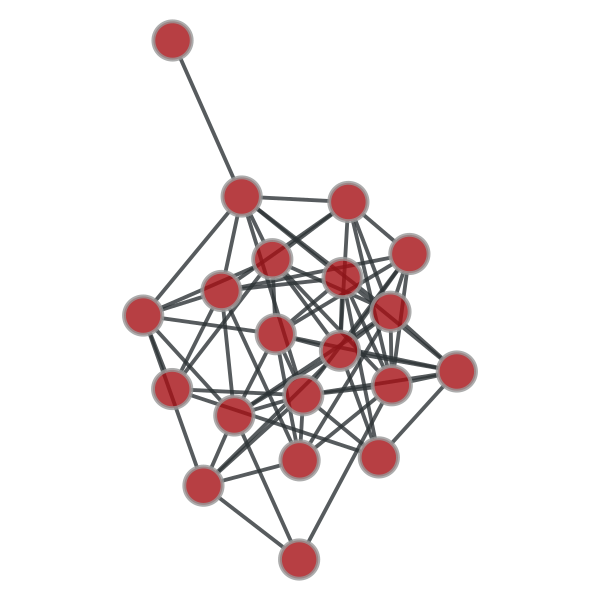

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fc7a82665f8, at 0x7fc7a82793c8>

In [88]:
N = 20
G = 2

g1 = specific_spatial(N,G)
g2 = specific_spatial_2(N,G)
g3 = specific_spatial_3(N,G)
g4 = rand_erdos_rand_pref(N,.4, G)

# gt.graph_draw(g1)
# gt.graph_draw(g2)
# gt.graph_draw(g3)
gt.graph_draw(g4)

In [68]:
# returns highest degree first order
def greedy_degree_order(network):
    order = [(i,v.out_degree()) for i,v in enumerate(network.vertices()) ]
    order.sort(key = operator.itemgetter(1), reverse=True)
    O = []
    for o in order:
        O.append(o[0])
    return O

In [7]:
def equal_size(num_groups, num_people):
    s = num_people // num_groups
    if num_people % num_groups != 0:
        s = s+1
    return s

In [64]:
def print_groups(network, groups):
    group_vp = network.new_vertex_property("int")
    for i, group in enumerate(groups):
        for agent in group:
            group_vp[network.vertex_index[agent]] = i      
    network.vp.group = group_vp
    pos = gt.sfdp_layout(network)
    gt.graph_draw(network, pos=pos, vertex_fill_color=group_vp)
    plt.show()

In [44]:
def util_func_vec(network):
    #CLUSTERING FRIENDSHIP MEASURE
    #return gt.local_clustering(network)
    
    #BETWEENESS FRIENDSHIP MEASURE
#     return gt.betweenness(network)[0]

    #CLOSENESS CENTRALITY
    #return gt.closeness(network, harmonic=True)

    #DEGREE
    vp = network.new_vertex_property("int")
    N = network.num_vertices()
    for v in network.vertices():
        vp[v] = v.out_degree() / N
    return vp
    

In [10]:
def mapping_2_util_vec_general(groups, network):
    num_people = len(network.get_vertices())
    G = [[False for i in range(num_people)] for j in range(len(groups))]
    for i,group in enumerate(groups):
        for person in group:
            G[i][person] = True
    Group_graphs = [gt.GraphView(network, G[i]) for i in range(len(G))]
    util = [util_func_vec(g) for g in Group_graphs]
    ret = []
    for person in range(num_people):
        p = network.vertex(person)
        #for i in range(len(G)):
        #    print(network.vp["pref"][p][i])
        p_util = [util[i][p] + network.vp.pref[p][i] for i in range(len(G))]
        ret.append(max(p_util))
    return ret

In [11]:
def BestResultClustering_general(groups, order, size, network):
    if len(order) == 0:
        u = mapping_2_util_vec_general(groups, network)
        return (u, groups)
    result = [float("-inf")] * len(groups)
    for i, group in enumerate(groups):
        if len(group) < size:
            tmp = copy.deepcopy(group)
            tmp.append(order[0])
            tmp_groups = copy.deepcopy(groups)
            tmp_groups[i] = tmp

            if len(order) == 1:
                result[i] = BestResultClustering_general(tmp_groups, [], size, network)
            else:
                result[i] =  BestResultClustering_general(tmp_groups, order[1:], size, network)
    best_vec = None
    best_groups = None
    score = float("-inf")
    for resu in result:
        if resu != float("-inf"):
            res = resu[0]
            s = 0
            for r in res:
                s += r
            groups = resu[1]
            if s > score:
                best_vec = res
                best_groups = groups
                score = s
    return (best_vec, best_groups)

In [12]:
def BackInductionClustering_general(groups, order, size, network):
    if len(order) == 0:
        u = mapping_2_util_vec_general(groups, network)
        return (u, groups)
    result = [float("-inf")] * len(groups)
    for i, group in enumerate(groups):
        if len(group) < size:
            tmp = copy.deepcopy(group)
            tmp.append(order[0])
            tmp_groups = copy.deepcopy(groups)
            tmp_groups[i] = tmp

            if len(order) == 1:
                result[i] = BackInductionClustering_general(tmp_groups, [], size, network)
            else:
                result[i] =  BackInductionClustering_general(tmp_groups, order[1:], size, network)
    best_vec = None
    best_groups = None
    score = float("-inf")
    for resu in result:
        if resu != float("-inf"):
            res = resu[0]
            groups = resu[1]
            if res[order[0]] > score:
                best_vec = res
                best_groups = groups
                score = res[order[0]]
    return (best_vec, best_groups)

In [13]:
def createDistanceMatrix(network):
    size = len(network.get_vertices())
    Matrix = [[float("NaN") for i in range(size)] for j in range(size)]
    
    for n, v  in enumerate(network.vertices()):
        Matrix[n][n] = 0
        for e in gt.bfs_iterator(network, v):
            Matrix[n] [network.vertex_index[e.target()]] = Matrix[n][network.vertex_index[e.source()]] + 1
    return Matrix 
def findFurthestGroup(network, n):
    Matrix = createDistanceMatrix(network)
    array = [float("inf") for i in range(n)]
    
    Max = 0;
    for j in range(len(network.get_vertices())):
        for k in range(j,len(network.get_vertices())):
            if Matrix[j][k] > Max :
                Max = Matrix[j][k]
                array[0] = j
                array[1] = k
    
    Temp = -1
    for i in range(2,n):
        Max = 0
        for j in range(len(network.get_vertices())):
            if j not in array:
                S=0
                for k in range(i):
                    S = S + Matrix[k][j]
                    if S>Max:
                        Max = S
                        Temp = j
            array[i]=Temp
    
    return array

In [14]:
def eiganseeding(network, num_groups):
    w = network.new_edge_property("double")
    w.a = np.random.random(len(w.a)) * 42
    ee, X = gt.eigenvector(network, w)
    actual = [X[v] for v in network.vertices()]
    ret =  np.argpartition(actual,-num_groups)[-num_groups:]
    return ret       

In [15]:
def degreeseeding(network, num_groups):
    nlargest = [(float("-inf"), float("-inf")) for i in range(num_groups)]
    actual = [v.out_degree() for v in network.vertices()]
    ret =  np.argpartition(actual,-num_groups)[-num_groups:]
    return ret

In [16]:
def random_graph_clustering_BI(N, p, num_groups, innitial_members = None):
    #small_graph = rand_erdos_rand_pref(N, p, num_groups)
    small_graph = specific_spatial(N, num_groups)
    order = greedy_degree_order(small_graph)
    groups = [[] for i in range(num_groups)]
    size = equal_size(num_groups, N)
    best = BestResultClustering_general(groups, order, size, small_graph)
    best_vec, best_groups = best[0], best[1]
    print("best global clustering: ", sum(best_vec))
    print("best outcomes: ", best_vec)
    print("best outcomes: ", best_groups)
    if innitial_members == "furthest":
        members = findFurthestGroup(small_graph, num_groups)
        for i, member in enumerate(members):
            try:
                order.remove(member)
                groups[i % len(groups)].append(member)
            except:
                print("FURTHEST DID NOT WORK IN THIS CASE: member=", member, "  order=", order)
    elif innitial_members == "eigan":
        members = eiganseeding(small_graph, num_groups)
        for i, member in enumerate(members):
            try:
                order.remove(member)
                groups[i % len(groups)].append(member)
            except:
                print("EIGAN DID NOT WORK IN THIS CASE: member=", member, "  order=", order)
    elif innitial_members == "deg":
        members = degreeseeding(small_graph, num_groups)
        for i, member in enumerate(members):
            try:
                order.remove(member)
                groups[i % len(groups)].append(member)
            except:
                print("DEG DID NOT WORK IN THIS CASE: member=", member, "  order=", order)
    BI = BackInductionClustering_general(groups, order, size, small_graph)
    BI, BI_groups = BI[0], BI[1]
    print("Backwards induction outcome: ", sum(BI))
    print("BI individual outcomes: ", BI)
    print("group allocation: ", BI_groups)
    print_groups(small_graph, best_groups)
    print_groups(small_graph, BI_groups)
    return (sum(BI) / sum(best_vec))

In [17]:
bars1 = []
bars2 = []
bars3 = []
bars4 = []
for N in range(len(results_1)):
    avg_poa_1 = sum(results_1[N])/len(results_1[N])
    avg_poa_2 = sum(results_2[N])/len(results_2[N])
    avg_poa_3 = sum(results_3[N])/len(results_3[N])
    avg_poa_4 = sum(results_4[N])/len(results_4[N])
    bars1.append(avg_poa_1)
    bars2.append(avg_poa_2)
    bars3.append(avg_poa_3)
    bars4.append(avg_poa_4)

    print("erdos-reyni graph of size ", N+3,":")
    print("    average PoA w/    no seeding: ", avg_poa_1)
    print("    average PoA w/    furthest seeding: ", avg_poa_2)
    print("    average PoA w/    eiganvec seeding: ", avg_poa_3)
    print("    average PoA w/    degree seeding: ", avg_poa_3)

# set width of bar
barWidth = 0.2
 
# set height of bar

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='#2d7f5e', width=barWidth, edgecolor='white', label='random graph PoA ')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='with furthest')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
plt.bar(r4, bars4, color='#557f2d', width=barWidth, edgecolor='white', label='var3')

 
# Add xticks on the middle of the group bars
plt.xlabel('Number Of People', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], range(3, 3 + len(results_1)))
 
# Create legend & Show graphic
#plt.legend()
plt.show()


NameError: name 'results_1' is not defined

In [18]:
# returns a list of length number of groups each with the valuation the agent has for that group
def group_valuations(network, groups, group_capacities, agent):
    util = []
    for i, group in enumerate(groups):
        if len(group) < group_capacities[i]:
            tmp = copy.deepcopy(group)
            tmp.append(agent)
            tmp_groups = copy.deepcopy(groups)
            tmp_groups[i] = tmp
            util.append(mapping_2_util_vec_general(tmp_groups, network)[agent])
        else:
            util.append(float("-inf"))
    return util

In [19]:
def independentCascade(network, num_groups, group_capacities):
    groups = [[] for i in range(num_groups)]
    group_assignment = network.new_vertex_property("int")
    cap = [0 for i in range(num_groups)]

    # assign all agents to their most preferred group (based only on pref)
    for i,v in enumerate(network.vertices()):
        r = range(num_groups)
        g = random.choice(r)
        group_assignment[v] = np.argmax(network.vp["pref"][v])
        cap[group_assignment[v]] += 1
        
    # in each iteration change each agents group based on their neighbors choices
    for i in range(500):
        for i,v in enumerate(network.vertices()):
            new_group = {}
            for w in v.out_neighbors():
                if group_assignment[w] not in new_group:
                    new_group[group_assignment[w]] = 1
                else:
                    new_group[group_assignment[w]] += 1
            chosen_group = None
            group_val = float("-inf")
            # set i's group to the group which it belives is best based on neighbors and preferences
            for item in new_group.items():
                if item[1] * network.vp["pref"][v][item[0]] * (-cap[item[0]]) > group_val:
                    group_val = item[1] * network.vp["pref"][v][item[0]] * (-cap[item[0]])
                    chosen_group = item[0]
            if random.random() < .6 and chosen_group != None:
                cap[group_assignment[v]] -= 1
                cap[chosen_group] += 1
                group_assignment[v] = chosen_group
    remaining = []
    for i, agent in enumerate(network.vertices()):
        choice = group_assignment[agent]
        if len(groups[choice]) < group_capacities[choice]:
            groups[choice].append(i)
        else:
            remaining.append(i)
    for agent in remaining:
        added = False
        for i,group in enumerate(groups):
            if not added:
                if len(group) < group_capacities[i]:
                    groups[i].append(agent)
                    added = True

    return groups

In [20]:
def IC_test(N, p, num_groups):
    small_graph = rand_erdos_rand_pref(N, p, num_groups)
    groups = [[] for i in range(num_groups)]
    size = equal_size(num_groups, N)
    group_capacities = [size for i in range(num_groups)]
    groups = independentCascade(small_graph, num_groups, group_capacities)
    order = greedy_degree_order(small_graph)
    best = BestResultClustering_general([[] for i in range(num_groups)], order, size, small_graph)
    best_vec, best_groups = best[0], best[1]
    #print("best global clustering: ", sum(best_vec))
    #print("best outcomes: ", best_vec)
    uv = mapping_2_util_vec_general(groups, small_graph)
    #print("IC utils: ", uv)
    #print("IC total: ", sum(uv))
    #print("PoA: ", sum(uv)/sum(best_vec))
    print_groups(small_graph, best_groups)
    print_groups(small_graph, groups)
    return (sum(uv)/sum(best_vec))

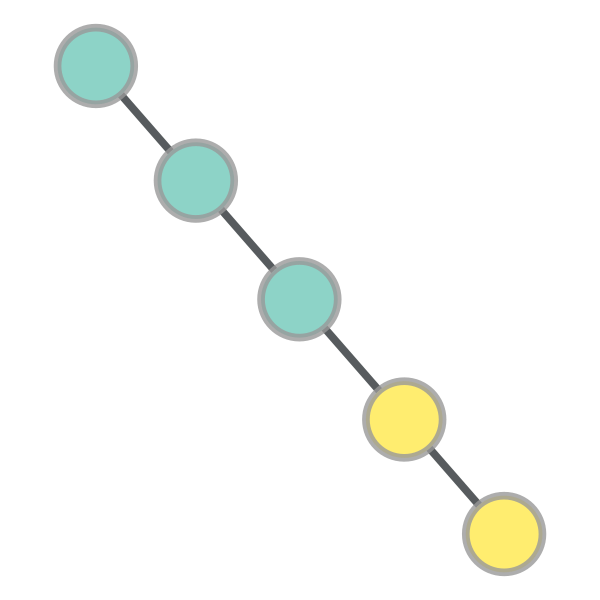

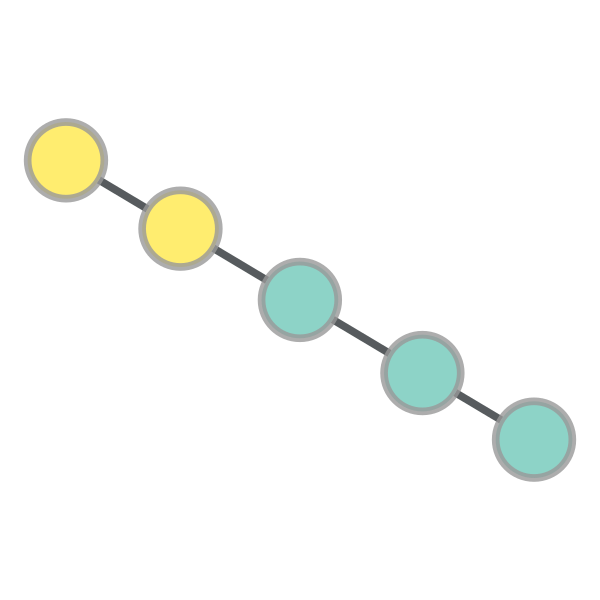

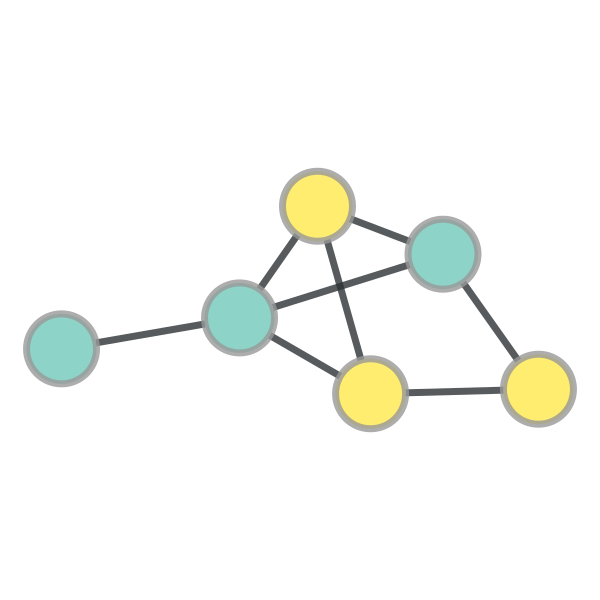

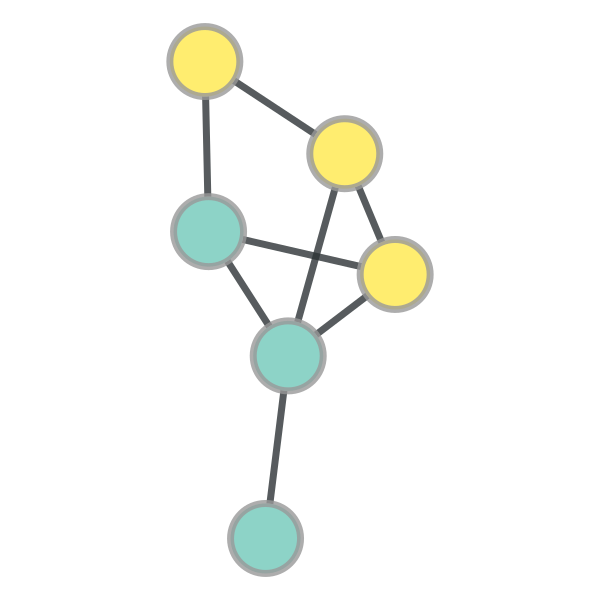

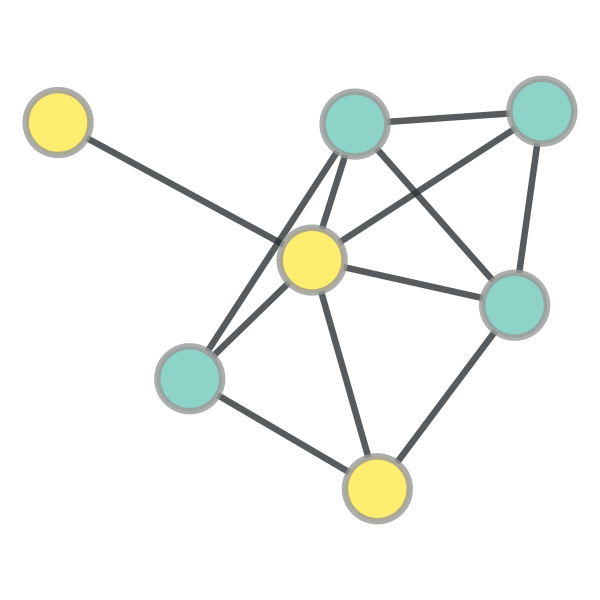

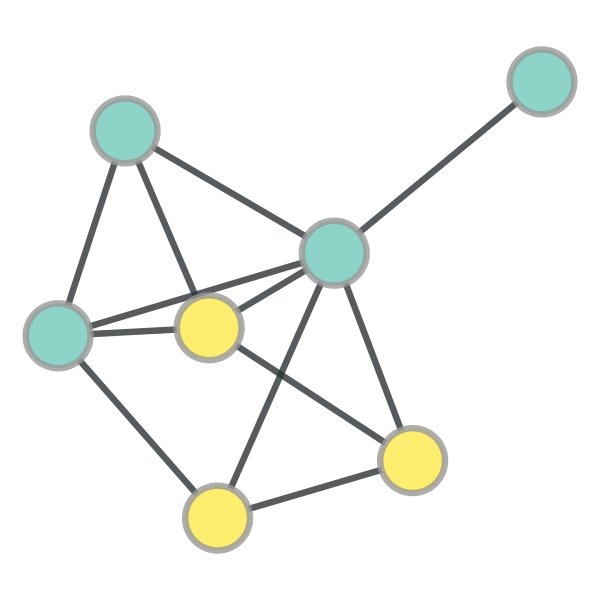

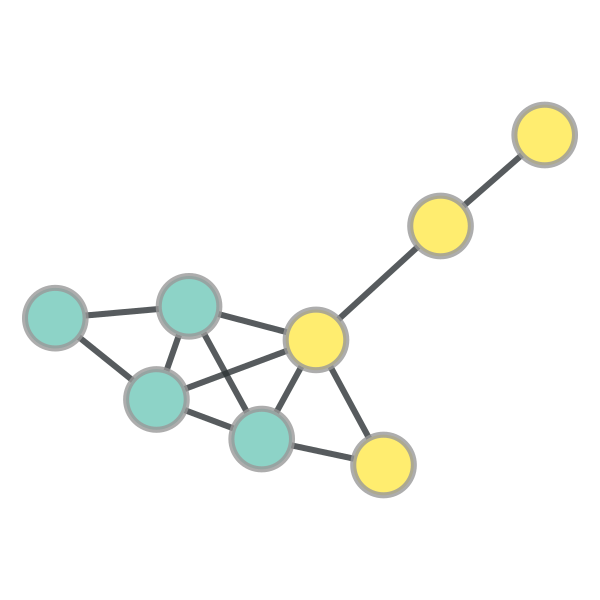

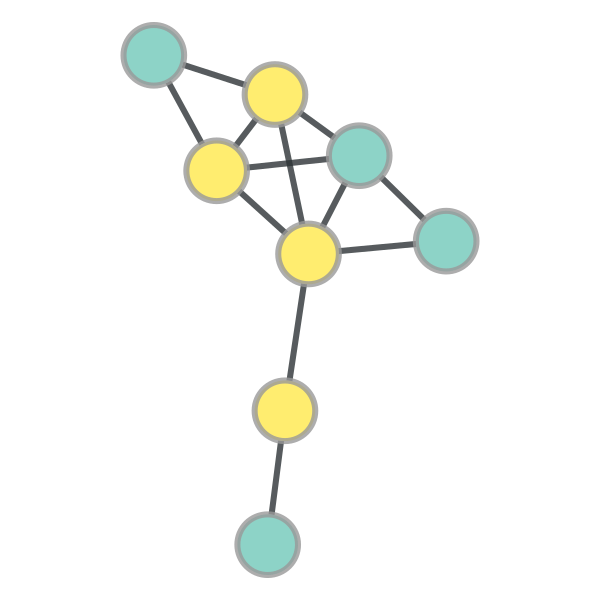

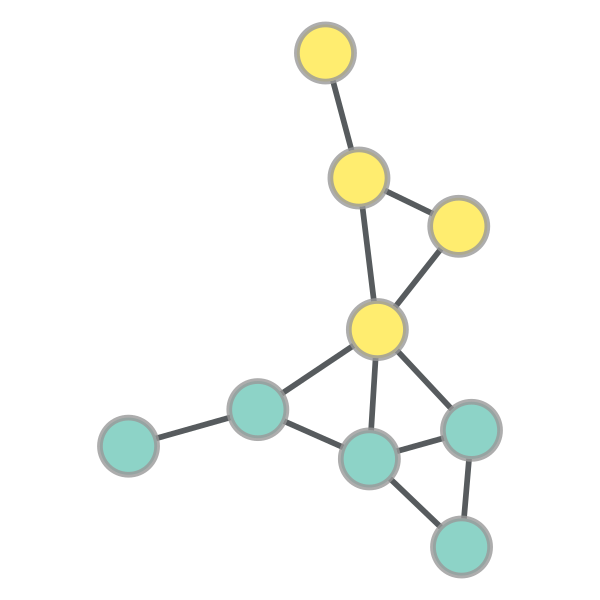

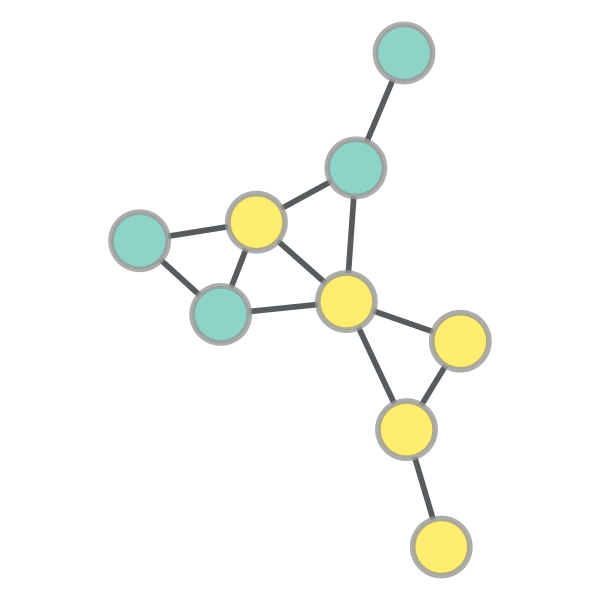

0.9280712147600242
0.7963095896886873
0.9976720371450394
0.6683373259499769
0.688829975164766


In [21]:
p = .4
num_groups = 2
results = [IC_test(N, p, num_groups) for N in range(5,10)]
for res in results:
    print(res)

In [22]:
def plurality_draft(network, num_groups, group_capacities):
    groups = [[] for i in range(num_groups)]
    # hieghst degree nodes are captains
    order = greedy_degree_order(network)
    captains = eiganseeding(network, num_groups)
    captains_group = {}
    assigned_agents = set()
    for cap in captains:
        mx = float("-inf")
        mx_group = None
        for g,pref in enumerate(network.vp["pref"][network.vertex_index[cap]]):
            if len(groups[g]) == 0:
                if pref > mx:
                    mx = pref
                    mx_group = g
        groups[mx_group].append(cap)
        captains_group[cap] = mx_group
        assigned_agents.add(cap)
    while(len(assigned_agents) < network.num_vertices()):
        for cap in captains:
            g = captains_group[cap]
            if len(assigned_agents) < network.num_vertices():
                members_choice = [None for i in range(len(groups[g]))]
                mx_val = [float("-inf") for i in range(len(groups[g]))]
                mx_agent = None
                for i,v in enumerate(network.vertices()):
                    if i not in assigned_agents:
                        tmp_group = copy.deepcopy(groups[g])
                        tmp_group.append(i)
                        tmp_groups = copy.deepcopy(groups)
                        tmp_groups[captains_group[cap]] = tmp_group
                        val = mapping_2_util_vec_general(tmp_groups, network)
                        member_val = []
                        for j, member in enumerate(groups[g]):
                            if val[member] > mx_val[j]:
                                mx_val[j] = val[member]
                                members_choice[j] = i
                counts = {}
                for mem in range(len(members_choice)):
                    selection = members_choice[mem]
                    if selection in counts:
                        counts[selection] += 1
                    else:
                        counts[selection] = 1
                mx_agent = None
                mx_count = float("-inf")
                for item in counts.items():
                    if item[1] > mx_count:
                        mx_agent = item[0]
                if mx_agent == None:
                    print("ERROR MX_AGENT == NONE")

                groups[g].append(mx_agent)
                assigned_agents.add(mx_agent)
    return groups

In [23]:
def captains_draft(network, num_groups, group_capacities):
    groups = [[] for i in range(num_groups)]
    # hieghst degree nodes are captains
    order = greedy_degree_order(network)
    captains = eiganseeding(network, num_groups)
    captains_group = {}
    assigned_agents = set()
    for cap in captains:
        mx = float("-inf")
        mx_group = None
        for g,pref in enumerate(network.vp["pref"][network.vertex_index[cap]]):
            if len(groups[g]) == 0:
                if pref > mx:
                    mx = pref
                    mx_group = g
        groups[mx_group].append(cap)
        captains_group[cap] = mx_group
        assigned_agents.add(cap)
    while(len(assigned_agents) < network.num_vertices()):
        for cap in captains:
            if len(assigned_agents) < network.num_vertices():
                mx_val = float("-inf")
                mx_agent = None
                for i,v in enumerate(network.vertices()):
                    if i not in assigned_agents:
                        tmp_group = copy.deepcopy(groups[captains_group[cap]])
                        tmp_group.append(i)
                        tmp_groups = copy.deepcopy(groups)
                        tmp_groups[captains_group[cap]] = tmp_group
                        val = mapping_2_util_vec_general(tmp_groups, network)[cap]
                        if val > mx_val:
                            mx_val = val
                            mx_agent = i
                if mx_agent == None:
                    print("ERRE MX_AGENT == NONE")
                groups[captains_group[cap]].append(mx_agent)
                assigned_agents.add(mx_agent)
    return groups

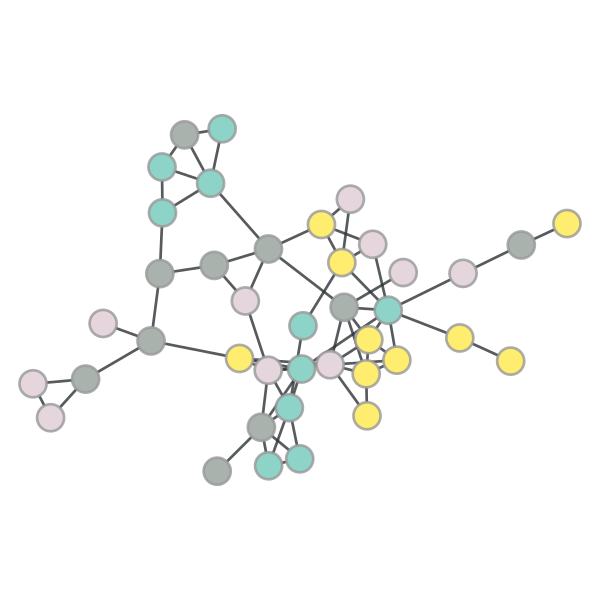

In [24]:
p = .2
N = 40
num_groups = 4
size = equal_size(num_groups, N)
group_capacities = [size for i in range(num_groups)]
graph = specific_spatial(N, num_groups)
groups = plurality_draft(graph, num_groups, group_capacities)
print_groups(graph, groups)

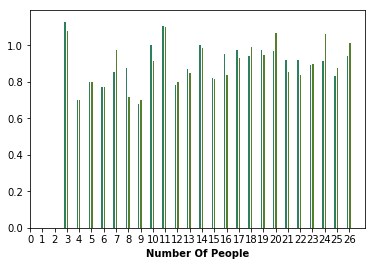

In [25]:
# Captains vs Plurality Draft
p = .35

results_plurality = []
results_captains = []
#results_bi = []
for n in range(3,30):
    num_groups = 3
    #graph = rand_erdos_rand_pref(n, p, num_groups)
    graph = specific_spatial(n, num_groups)
    groups = [[] for i in range(num_groups)]
    order = greedy_degree_order(graph)
    size = equal_size(num_groups, n)
    group_capacities = [size for i in range(num_groups)]
    results_plurality.append(mapping_2_util_vec_general(plurality_draft(graph, num_groups, group_capacities), graph))
    results_captains.append(mapping_2_util_vec_general(captains_draft(graph, num_groups, group_capacities), graph))
    #results_bi.append(mapping_2_util_vec_general(BackInductionClustering_general(groups, order, size, graph)[1], graph))
bars1 = []
bars2 = []
bars3 = []
for i in range(len(results_plurality)):
    bars1.append(sum(results_plurality[i])/len(results_plurality[i]))
    bars2.append(sum(results_captains[i])/len(results_captains[i]))
    #bars3.append(sum(results_bi[i]))


barWidth = 0.2
 
# set height of bar

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#2d7f5e', width=barWidth, edgecolor='white', label='random graph PoA ')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='with furthest')
#plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')

 
# Add xticks on the middle of the group bars
plt.xlabel('Number Of People', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], range(len(results_plurality)))
 
# Create legend & Show graphic
#plt.legend()
plt.show()

In [26]:
def envy_check(groups, network):
    ef_num = 0
    for i,group in enumerate(groups):
        for agent in group:
            u_0 = mapping_2_util_vec_general(groups, network)[agent]
            for j,group_alt in enumerate(groups):
                if i != j:
                    tmp_group_alt = copy.deepcopy(group_alt)
                    tmp_group = copy.deepcopy(group)
                    tmp_group_alt.append(agent)
                    tmp_group.remove(agent)
                    tmp_groups = copy.deepcopy(groups)
                    tmp_groups[i] = tmp_group
                    tmp_groups[j] = tmp_group_alt
                    u_g = mapping_2_util_vec_general(tmp_groups, network)[agent]
                    if u_g > u_0:
                        found_ef = False
                        for agent_to_remove in group_alt:
                            if agent_to_remove != agent:
                                ef_1 = copy.deepcopy(tmp_group_alt)
                                ef_1.remove(agent_to_remove)
                                tmp_groups_ef = copy.deepcopy(tmp_groups)
                                tmp_groups_ef[j] = ef_1
                                u_ef = mapping_2_util_vec_general(tmp_groups_ef, network)[agent]
                                if u_0 >= u_ef:
                                    found_ef = True
                                    ef_num = max(ef_num, 1)
                        if not found_ef:
                            for agent_to_remove_1 in group_alt:
                                for agent_to_remove_2 in group_alt:
                                    if agent_to_remove_1 != agent_to_remove_2 and agent_to_remove_1 != agent and agent_to_remove_2 != agent:
                                        ef_2 = copy.deepcopy(tmp_group_alt)
                                        ef_2.remove(agent_to_remove_1)
                                        ef_2.remove(agent_to_remove_2)
                                        tmp_groups_ef = copy.deepcopy(tmp_groups)
                                        tmp_groups_ef[j] = ef_1
                                        u_ef = mapping_2_util_vec_general(tmp_groups_ef, network)[agent]
                                        if u_0 >= u_ef:
                                            found_ef = True
                                            ef_num = max(ef_num, 2)
                        if not found_ef:
                            for atr1 in group_alt:
                                for atr2 in group_alt:
                                    for atr3 in group_alt:
                                        if atr1 != atr2 and atr1 != atr3 and atr2 != atr3 and agent != atr1 and agent != atr2 and agent != atr3:
                                            ef_3 = copy.deepcopy(tmp_group_alt)
                                            ef_3.remove(atr1)
                                            ef_3.remove(atr2)
                                            ef_3.remove(atr3)
                                            tmp_groups_ef = copy.deepcopy(tmp_groups)
                                            tmp_groups_ef[j] = ef_1
                                            u_ef = mapping_2_util_vec_general(tmp_groups_ef, network)[agent]
                                            if u_0 >= u_ef:
                                                found_ef = True
                                                ef_num = max(ef_num, 3)
                        if not found_ef:
                            ef_num = float("inf")
                            
    return ef_num
        
    # for each agent i
        # for each alternative group g
            # if i prefers g to i's current group
                # discover minimum amount of agents that need to be removed from g for i to prefer i's group to g
    # return max agent removal needed for envy freeness

In [27]:
def alpha_stable(alpha, groups, network):
    for i, group in enumerate(groups):
        for agent in group:
            u_0 = mapping_2_util_vec_general(groups, network)[agent]
            for j, group_alt in enumerate(groups):
                if i != j:
                    tmp_group_alt = copy.deepcopy(group_alt)
                    tmp_group = copy.deepcopy(group)
                    tmp_group_alt.append(agent)
                    tmp_group.remove(agent)
                    tmp_groups = copy.deepcopy(groups)
                    tmp_groups[i] = tmp_group
                    tmp_groups[j] = tmp_group_alt
                    u_g = mapping_2_util_vec_general(tmp_groups, network)[agent]
                    if u_g > u_0 * alpha:
                        return False
    return True


In [28]:
def alpha_check(groups, network):
    alpha = 1
    while not alpha_stable(alpha, groups, network):
        alpha += .1
    return alpha

In [29]:
def modularity_communities(network):
    communities_vp = network.new_vertex_property("int")
    communities = []
    for i,v in enumerate(network.vertices()):
        communities.append([i])
        communities_vp[v] = i
    merges = []
    old_modularity = None
    new_modularity = gt.modularity(network, communities_vp)
    while old_modularity is None or new_modularity > old_modularity:
        old_modularity = new_modularity
        trial_communities = copy.deepcopy(communities)
        trial_communities_vp = network.new_vertex_property("int")
        for i,comm in enumerate(trial_communities):
            for agent in comm:
                trial_communities_vp[agent] = i
        to_merge = None
        for i,u in enumerate(communities):
            for j,v in enumerate(communities):
                if j <=i or len(u) == 0 or len(v) == 0:
                    continue
                for agent in u:
                    trial_communities[j].append(agent)
                    trial_communities_vp[agent] = j
                trial_communities[i] = []
                trial_modularity = gt.modularity(network, trial_communities_vp)
                if trial_modularity >= new_modularity:
                    new_modularity = trial_modularity
                    to_merge = (i, j, new_modularity - old_modularity)
                elif ( to_merge and min(i,j) < min(to_merge[0], to_merge[1])):
                    new_modularity = trial_modularity
                    to_merge = (i, j, new_modularity - old_modularity)
                trial_communities[j] = v
                for agent in u:
                    trial_communities_vp[agent] = i
        if to_merge is not None:
            merges.append(to_merge)
            i, j, dq = to_merge
            u,v = communities[i], communities[j]
            for agent in u:
                communities[j].append(agent)
                communities_vp[agent] = j
            communities[i] = []
        communities = sorted([c for c in communities if len(c) > 0], key=lambda x: len(x), reverse=True)
        return communities

In [30]:
def modularity_assignment(network, num_groups, group_capacities):
    groups = [[] for i in range(num_groups)]
    communities = modularity_communities(network)
    leftovers = []
    for community in communities:
        votes = {}
        for agent in community:
            choice = np.argmax(network.vp["pref"][agent])
            if choice in votes.keys():
                votes[choice] += 1
            else:
                votes[choice] = 1
        mx = float("-inf")
        choice = None
        for vote in votes.items():
            if vote[1] > mx:
                mx = vote[1]
                choice = vote[0]
        for agent in community:
            if len(groups[choice]) < group_capacities[choice]:
                groups[choice].append(agent)
            else:
                leftovers.append(agent)
    for agent in leftovers:
        added = False
        for i,group in enumerate(groups):
            if not added:
                if len(group) < group_capacities[i]:
                    groups[i].append(agent)
                    added = True
    return groups

In [31]:
# I talked to lirong:
    # EF & sum(SW) are alright measure
    # I should note which agents the algorithms are best for
    #  / in which situation these algo's work

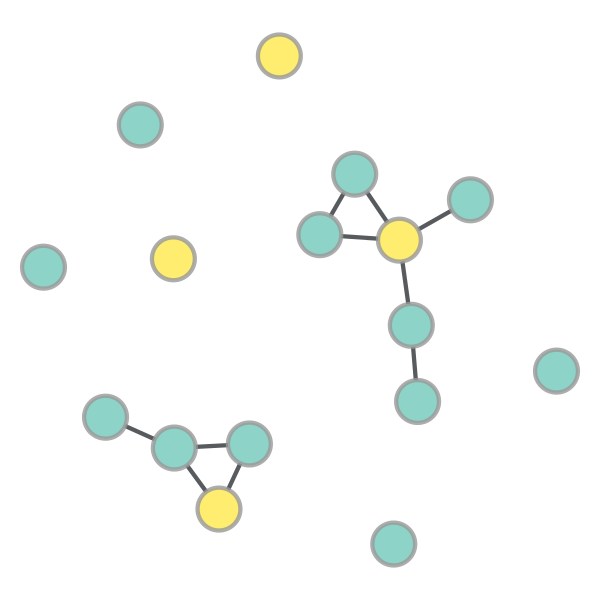

In [32]:
p = .2
N = 16
num_groups = 2
size = equal_size(num_groups, N)
group_capacities = [size for i in range(num_groups)]
graph = specific_spatial(N, num_groups)
groups = modularity_assignment(graph, num_groups, group_capacities)
print_groups(graph, groups)

In [33]:
alpha_stable(2, groups, graph)

True

In [34]:
#TESTING

In [35]:
def erdos_test(N, num_groups):
    graph_1 = rand_erdos_rand_pref(N, .4, num_groups)
    gt.graph_draw(graph_1)
    order = greedy_degree_order(graph_1)
    groups = [[] for i in range(num_groups)]
    size = equal_size(num_groups, N)
    group_capacities = [size for i in range(num_groups)]
    best_outcome = BestResultClustering_general(groups, order, size, graph_1)
    best_groups = best_outcome[1]
    best_sw = sum(best_outcome[0])
    BI = BackInductionClustering_general(groups, order, size, graph_1)
    BI_groups = BI[1]
    IC_groups = independentCascade(graph_1, num_groups, group_capacities)
    captains_groups = captains_draft(graph_1, num_groups, group_capacities)
    plurality_groups = plurality_draft(graph_1, num_groups, group_capacities)
    modularity_groups = modularity_assignment(graph_1, num_groups, group_capacities)

    group_assignments = [BI_groups, IC_groups, captains_groups, plurality_groups, modularity_groups]
    names = ["BI_groups", "IC_groups", "captains_groups", "plurality_groups", "modularity_groups"]
    PoA = []
    EF = []
    Alpha = []
    for name, assignment in zip(names,group_assignments):
        util_vec = mapping_2_util_vec_general(assignment, graph_1)
        print(name)
        print("   assignment: ", assignment)
        print("   Sum(SW): ", sum(util_vec))
        poa = sum(util_vec)/best_sw
        PoA.append(poa)
        print("   Sum(SW)/Sum(SW*): ", poa)
        ef = envy_check(assignment, graph_1)
        EF.append(ef)
        print("   EF#: ", ef)
        alpha = alpha_check(assignment, graph_1)
        Alpha.append(alpha)
        print("   Alpha#: ", alpha)
    return (PoA, EF, Alpha)

In [57]:
def spatial_test(N, num_groups):
    graph_1 = specific_spatial_3(N, num_groups)
    #gt.graph_draw(graph_1)
    order = greedy_degree_order(graph_1)
    groups = [[] for i in range(num_groups)]
    size = equal_size(num_groups, N)
    group_capacities = [size for i in range(num_groups)]
#     best_outcome = BestResultClustering_general(groups, order, size, graph_1)
#     best_groups = best_outcome[1]
#     best_sw = sum(best_outcome[0])
#     BI = BackInductionClustering_general(groups, order, size, graph_1)
#     BI_groups = BI[1]
    IC_groups = independentCascade(graph_1, num_groups, group_capacities)
    captains_groups = captains_draft(graph_1, num_groups, group_capacities)
    plurality_groups = plurality_draft(graph_1, num_groups, group_capacities)
#     modularity_groups = modularity_assignment(graph_1, num_groups, group_capacities)

    group_assignments = [IC_groups, captains_groups, plurality_groups]
    names = ["IC_groups", "captains_groups", "plurality_groups"]
    AVG = []
    EF = []
    Alpha = []
    LOW = []
    for name, assignment in zip(names,group_assignments):
        util_vec = mapping_2_util_vec_general(assignment, graph_1)
#         print(name)
#         print("   assignment: ", assignment)
        avg = sum(util_vec)/len(util_vec)
        AVG.append(avg)
        
        low=min(util_vec)
        LOW.append(low)
#         print("   average SW: ", avg) 
#         poa = sum(util_vec)/best_sw
#         PoA.append(poa)
#         print("   Sum(SW)/Sum(SW*): ", poa)
        ef = envy_check(assignment, graph_1)
        EF.append(ef)
#         print("   EF#: ", ef)
        alpha = alpha_check(assignment, graph_1)
        Alpha.append(alpha)
#         print("   Alpha#: ", alpha)
    return (AVG, LOW, EF, Alpha)

In [62]:
Best = [0,0, [], 0]
BI = [0,0,[], 0]
IC = [0, 0, [], 0]
cap = [0,0, [], 0]
plur = [0,0, [], 0]
mod = [0, 0, [], 0]
r = 50
for i in range(r):
    avg, low, EF, Alpha = spatial_test(20, 6)
#     Best[0] += avg[0]
#     Best[2].append(EF[0])
#     Best[3] += Alpha[0]
    
#     BI[0] += avg[]
#     BI[2].append(EF[1])
#     BI[3] += Alpha[1]

#     mod[0] += avg[5]
#     mod[2].append(EF[5])
#     mod[3] += Alpha[5]
    
    IC[0] += avg[0]
    IC[1] += low[0]
    IC[2].append(EF[0])
    IC[3] += Alpha[0]
    
    cap[0] += avg[1]
    cap[1] += low[1]
    cap[2].append(EF[1])
    cap[3] += Alpha[1]
    
    plur[0] += avg[2]
    plur[1] += low[2]
    plur[2].append(EF[2])
    plur[3] += Alpha[2]


# print("Best")
# print("    Avg:   ", Best[0]/r)
# print("    Min:   ", Best[1]/r)
# print("    EF:    ", collections.Counter(Best[2]))
# print("    Alpha: ", Best[3]/r)


# print("BI")
# print("    Avg:   ", BI[0]/r)
# print("    Min:   ", BI[1]/r)
# print("    EF:    ", collections.Counter(BI[2]))
# print("    Alpha: ", BI[3]/r)

# print("Modularity Assignment")
# print("    Avg:   ", mod[0]/r)
# print("    Min:   ", mod[1]/r)
# print("    EF:    ", collections.Counter(mod[2]))
# print("    Alpha: ", mod[3]/r)


print("IC")
print("    Avg:   ", IC[0]/r)
print("    Min:   ", IC[1]/r)
print("    EF:    ", collections.Counter(IC[2]))
print("    Alpha: ", IC[3]/r)


print("Captains draft")
print("    Avg:   ", cap[0]/r)
print("    Min:   ", cap[1]/r)
print("    EF:    ", collections.Counter(cap[2]))
print("    Alpha: ", cap[3]/r)


print("Plurality Draft")
print("    Avg:   ", plur[0]/r)
print("    Min:   ", plur[1]/r)
print("    EF:    ", collections.Counter(plur[2]))
print("    Alpha: ", plur[3]/r)

IC
    Avg:    1.3859943161843673
    Min:    0.679239153152449
    EF:     Counter({inf: 50})
    Alpha:  4.151999999999999
Captains draft
    Avg:    1.5711493237978744
    Min:    0.7276009111627887
    EF:     Counter({inf: 49, 1: 1})
    Alpha:  3.0540000000000007
Plurality Draft
    Avg:    1.6227679965354533
    Min:    0.7081995317018991
    EF:     Counter({inf: 48, 1: 2})
    Alpha:  3.234000000000002


[1, 1, 1]


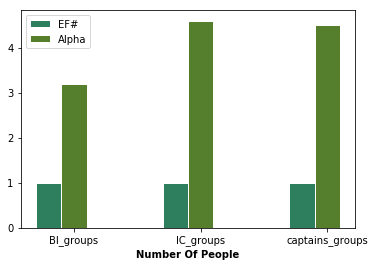

In [70]:
PoA, EF, Alpha = spatial_test(20, 3)
bars1 = []
bars2 = []
for outcome in zip(EF, Alpha):
    bars1.append(outcome[0])
    bars2.append(outcome[1])
# set width of bar
print(bars1)
barWidth = 0.2
 
# set height of bar

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#2d7f5e', width=barWidth, edgecolor='white', label='EF# ')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Alpha')

 
# Add xticks on the middle of the group bars
plt.xlabel('Number Of People', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ["BI_groups", "IC_groups", "captains_groups", "plurality_groups", "modularity_groups"])
 
# Create legend & Show graphic
plt.legend()
plt.show()
